# Power Plant Load Factors

<br>

### Imports

In [9]:
import numpy as np
import pandas as pd

import dask
import dask.dataframe as dd

import os
import warnings
from tqdm import tqdm

<br>

### User Inputs

In [2]:
static_data_dir = 'C:/Users/Ayrto/Desktop/Freelance Work/FEA/work/data-hub/data/static'
powerdict_fp = 'C:/Users/Ayrto/Desktop/Side Projects/Power-Station-Dictionary/data/dictionary/ids.csv'

In [3]:
@dask.delayed
def read_B1610_file(filename, columns):
    df_B1610_week = pd.read_csv(filename)
    cols_to_add = list(set(columns) - set(df_B1610_week.columns))
    df_B1610_week[cols_to_add] = np.NaN
    df_B1610_week = df_B1610_week[columns]
    
    return df_B1610_week

def get_B1610_columns(static_dir, source_name='bmrs', stream='B1610'):
    B1610_files = [f for f in os.listdir(f'{static_dir}/{source_name}/{stream}') if '.csv' in f]

    columns = []

    for B1610_file in tqdm(B1610_files):
        df_B1610_week = pd.read_csv(f'{static_dir}/{source_name}/{stream}/{B1610_file}')
        columns += list(df_B1610_week.columns)

    columns = ['datetime'] + sorted(list(set(columns)-set(['datetime'])))

    return columns

def load_B1610_dask_stream_df(static_dir, source_name, stream, dt_col='datetime'):
    # Identifying columns
    columns = get_B1610_columns(static_dir)
    
    # Loading data
    B1610_files = [f for f in os.listdir(f'{static_dir}/{source_name}/{stream}') if '.csv' in f]
    df_B1610 = dd.from_delayed([read_B1610_file(f'{static_dir}/{source_name}/{stream}/{B1610_file}', columns) for B1610_file in B1610_files])

    # Formatting date index
    if dt_col is not None:
        df_B1610[dt_col] = df_B1610[dt_col].map(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S', errors='coerce', utc=True))
        df_B1610 = df_B1610.set_index(dt_col)
    
    return df_B1610

In [4]:
%%time

source_name = 'bmrs'
stream = 'B1610'

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    df_B1610 = load_B1610_dask_stream_df(static_data_dir, source_name, stream).compute()   

df_B1610.head(3)

100%|██████████| 288/288 [00:17<00:00, 16.00it/s]


Wall time: 2min 56s


,ABRBO-1,ABRTW-1,ABTH7,ABTH7G,ABTH8,ABTH8G,ABTH9,ABTH9G,ACHRW-1,AKGLW-2,...,WILCT-1,WLNYO-2,WLNYO-3,WLNYO-4,WLNYW-1,WTMSO-1,WYLF-1,WYLF-2,WYLF-3,WYLF-4
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-04 23:00:00+00:00,NaN,NaN,421.692,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,132.90,NaN,NaN,95.602,9.858,227.380,212.41,NaN,NaN
2015-10-04 23:30:00+00:00,NaN,NaN,425.096,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,143.02,NaN,NaN,107.324,14.890,227.470,212.53,NaN,NaN
2015-10-05 00:00:00+00:00,NaN,NaN,423.292,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.98,NaN,NaN,118.342,23.074,227.666,212.72,NaN,NaN


In [5]:
df_powerdict = pd.read_csv(powerdict_fp)

df_powerdict.head(3)

,dictionary_id,gppd_idnr,esail_id,name,sett_bmu_id,ngc_bmu_id,4c_offshore_id,windpowernet_id,wikidata_id,wikipedia_id,power_technology_id,eutl_id,eic_id,cfd_id,jrc_id,iaea_id,old_repd_id,new_repd_id
0,10000,NaN,MARK,Rothes Bio-Plant CHP,"E_MARK-1, E_MARK-2","MARK-1, MARK-2",NaN,NaN,NaN,NaN,NaN,NaN,48W000000MARK-1D,NaN,NaN,NaN,NaN,NaN
1,10001,"GBR1000377, GBR1000369",DIDC,Didcot,"T_DIDC1, T_DIDC2, T_DIDC4, T_DIDC3, T_DIDC1G, ...","DIDC1, DIDC2, DIDC4, DIDC3, DIDC1G, DIDC2G, DI...",NaN,NaN,NaN,NaN,NaN,97165,"48W00000DIDC01G1, 48W00000DIDC02GZ, 48W00000DI...",NaN,NaN,NaN,NaN,NaN
2,10002,"GBR1000374, GBR1000375",ABTH,Aberthaw B,"T_ABTH7, T_ABTH8, T_ABTH9, T_ABTH7G, T_ABTH8G,...","ABTH7, ABTH8, ABTH9, ABTH7G, ABTH8G, ABTH9G",NaN,NaN,Q4667192,Aberthaw_power_stations,NaN,97175,"48W0000000ABTH7Y, 48W0000000ABTH8W, 48W0000000...",NaN,NaN,NaN,NaN,NaN


In [6]:
flatten_list = lambda list_: [item for sublist in list_ for item in sublist]

powerdict_ngc_bmu_ids = sorted(list(set(flatten_list(df_powerdict['ngc_bmu_id'].dropna().str.split(', ').to_list()))))

len(powerdict_ngc_bmu_ids)

444

In [7]:
B1610_ngc_bmu_ids = sorted(list(df_B1610.columns))

missing_ngc_bmu_ids_from_powerdict = sorted(list(set(B1610_ngc_bmu_ids) - set(powerdict_ngc_bmu_ids)))

missing_ngc_bmu_ids_from_powerdict

['GRAI1G', 'GRAI4G', 'KNLCV-1', 'LCSMH-1', 'SEEL-1', 'WILCT-1']

In [11]:
s_load_factors = (df_B1610.resample('Y').mean()/df_B1610.max()).stack().dropna()
s_load_factors.index = pd.MultiIndex.from_arrays([s_load_factors.index.get_level_values(0).year, s_load_factors.index.get_level_values(1)], names=['year', 'ngc_bmu_id'])
s_load_factors.name = 'load_factor'

s_load_factors

year  ngc_bmu_id
2015  ABTH7         0.743227
      ABTH7G        0.002164
      ABTH8         0.764681
      ABTH8G        0.002478
      ABTH9         0.044415
                      ...   
2021  WLNYO-2       0.472969
      WLNYO-3       0.487233
      WLNYO-4       0.435120
      WLNYW-1       0.400564
      WTMSO-1       0.498671
Name: load_factor, Length: 1806, dtype: float64

In [14]:
s_full_load_hours = (df_B1610.resample('Y').sum()/df_B1610.max()).stack().replace(0, np.nan).dropna().round(2)
s_full_load_hours.index = pd.MultiIndex.from_arrays([s_full_load_hours.index.get_level_values(0).year, s_full_load_hours.index.get_level_values(1)], names=['year', 'ngc_bmu_id'])
s_full_load_hours.name = 'full_load_hours'




year  ngc_bmu_id
2015  ABTH7         2748.45
      ABTH7G           0.73
      ABTH8         3231.54
      ABTH8G           0.83
      ABTH9           14.92
                     ...   
2021  WLNYO-2       2609.84
      WLNYO-3       2688.55
      WLNYO-4       2108.59
      WLNYW-1       2210.31
      WTMSO-1       2751.66
Name: full_load_hours, Length: 1803, dtype: float64

In [27]:
df_load_stats = pd.concat([s_load_factors.to_frame(), s_full_load_hours.to_frame()]).sort_index().stack().unstack()

df_load_stats.head()

load_factor  full_load_hours
year ngc_bmu_id                              
2015 ABTH7          0.743227          2748.45
     ABTH7G         0.002164             0.73
     ABTH8          0.764681          3231.54
     ABTH8G         0.002478             0.83
     ABTH9          0.044415            14.92

<AxesSubplot:xlabel='load_factor', ylabel='Count'>

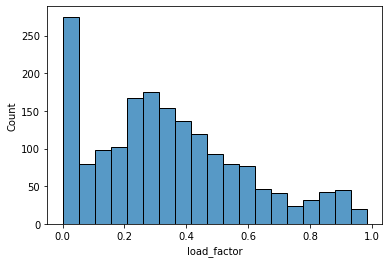

In [29]:
import seaborn as sns

sns.histplot(df_load_stats['load_factor'])

In [30]:
save_data = False

if save_data == True:
    df_load_stats.reset_index().to_csv('../datasets/load-factors/load-factors.csv', index=False)